# <center>Breast Cancer Classification on DenseNet Model</center>

### Dataset Download from kaggle 

[Link](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

In [1]:
!ls

Model_comparison.ipynb
classification.ipynb
densenet_model.ipynb
models
resnet152.ipynb
resnet152_with_applied_paper.ipynb
resnext_model.ipynb
sample_submission.csv
submission_transferLearning_0.9872716665267944.csv
test
train
train_labels.csv


## Import packages

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from torchvision.models import * 

import os
import matplotlib.pyplot as plt

## Exploratory data analysis

In [4]:
path = Path(".")
labels = pd.read_csv(path/"train_labels.csv")
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
print(labels["label"].nunique()); classes = list(set(labels["label"])); classes

2


[0, 1]

### Class Distribution

In [6]:
for i in classes:
    print("Number of items in class {} is {}".format(i,len(labels[labels["label"] == i])))

Number of items in class 0 is 130908
Number of items in class 1 is 89117


## Data Visualisation

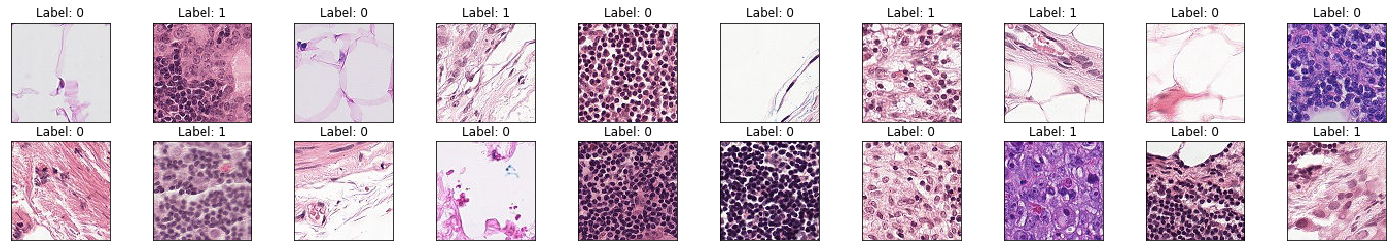

In [7]:
fig = plt.figure(figsize=(25, 4))
from PIL import Image as image_open
# display 20 images
train_imgs = os.listdir("./train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = image_open.open("./train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

## Data loading and preparation with data augmentation

### Transform image with flip, invert and zoom

In [8]:
tfms = get_transforms(do_flip = True,flip_vert = True,max_zoom = 1.1)

In [9]:
np.random.seed(123)
sz = 96
data = ImageDataBunch.from_csv(path, folder = 'train', csv_labels = "train_labels.csv",
                               test = 'test',suffix=".tif", size = sz,bs = 128,
                               ds_tfms = tfms)
data.path = pathlib.Path('.')
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: .;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,1,0,1,1
Path: .;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: .

In [10]:
print(data.classes); data.c

[0, 1]


2

In [11]:
import fastai
fastai.__version__

'1.0.54'

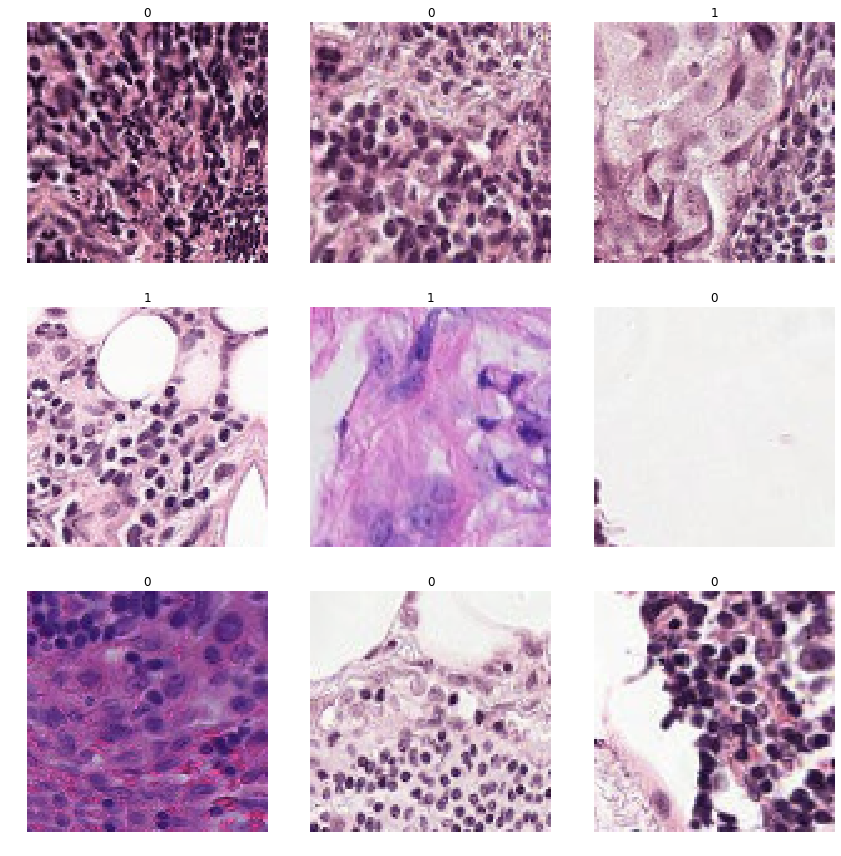

In [12]:
data.show_batch(rows = 3)

## Applying Model

### Model validation matrix - auc score

In [13]:
from sklearn.metrics import roc_auc_score

def auc_score(y_pred,y_true,tens=True):
    score = roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score = tensor(score)
    return score

## Training model with 

### 2. DenseNet


In [14]:
from fastai.basics import *

In [17]:
arch = models.densenet121
learn = cnn_learner(data,arch,pretrained = True,ps = 0.5,metrics = [auc_score,accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


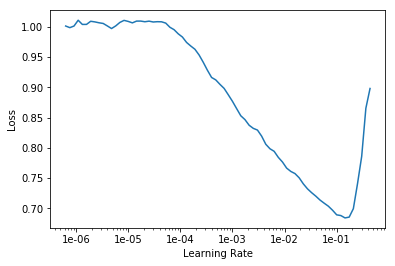

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(8,1e-2)

epoch,train_loss,valid_loss,auc_score,accuracy,time
0,0.207758,0.195513,0.973679,0.931644,09:15
1,0.203684,0.306668,0.962975,0.884468,09:07
2,0.192821,0.255612,0.974312,0.901716,09:13
3,0.167857,0.164186,0.983365,0.938416,09:16
4,0.158005,0.190131,0.979608,0.934167,06:20
5,0.134999,0.129032,0.988682,0.953778,04:47
6,0.136007,0.118281,0.989985,0.957550,04:50
7,0.131702,0.113934,0.990474,0.959209,04:51


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


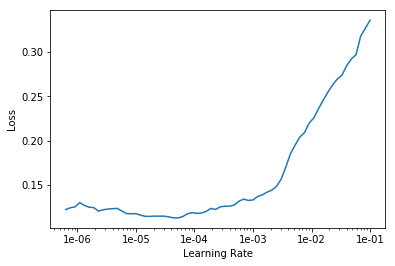

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2,max_lr = slice(1e-5,1e-3))

epoch,train_loss,valid_loss,auc_score,accuracy,time
0,0.140399,0.118195,0.990134,0.957346,05:33
1,0.118007,0.113105,0.990918,0.959777,05:29


In [23]:
learn.save('stage-2')

In [24]:
preds,y = learn.TTA()
acc = accuracy(preds, y)
print('The validation accuracy is {} %.'.format(acc * 100))
pred_score = auc_score(preds,y).item()
print('The validation AUC is {}.'.format(pred_score))

The validation accuracy is 96.1527099609375 %.
The validation AUC is 0.9914546608924866.


## Model interpretation

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

## Top losses with FP, TN

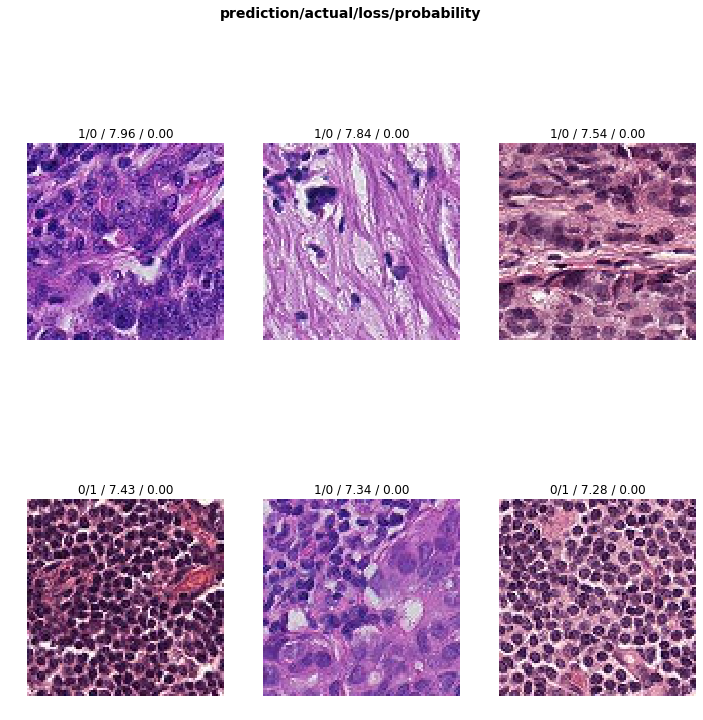

In [26]:
interp.plot_top_losses(6)

### Confusion Matrix

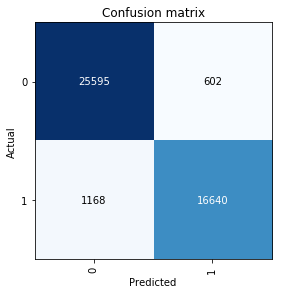

In [27]:
interp.plot_confusion_matrix()